In [17]:
!pip install numpy matplotlib pandas tqdm


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
with open("metrics.json", encoding="utf-8") as f:
    data = json.load(f)

In [20]:
pd.set_option('display.max_rows', 10)

df = pd.DataFrame(data)
df = df[df['size'] == df['size'].max()]
df.sort_values("duration", ascending=True)

,duration,value,block_size,grid_size,size,runtime,device
513,0.120389,2.999808,1024.0,32768.0,900000000,OpenCL Reduction,NVIDIA GeForce RTX 2060
512,0.120406,2.999789,1024.0,16384.0,900000000,OpenCL Reduction,NVIDIA GeForce RTX 2060
1019,0.120552,2.999808,1024.0,32768.0,900000000,CUDA Reduction,NVIDIA GeForce RTX 2060
511,0.120554,2.999800,1024.0,8192.0,900000000,OpenCL Reduction,NVIDIA GeForce RTX 2060
1017,0.120578,2.999800,1024.0,8192.0,900000000,CUDA Reduction,NVIDIA GeForce RTX 2060
...,...,...,...,...,...,...,...
1025,0.154660,2.999798,NaN,NaN,900000000,cuBLAS,NVIDIA GeForce RTX 2060
518,0.170639,2.998854,1024.0,1048576.0,900000000,OpenCL Reduction,NVIDIA GeForce RTX 2060
1024,0.173277,2.998853,1024.0,1048576.0,900000000,CUDA Reduction,NVIDIA GeForce RTX 2060
520,0.419266,2.822655,NaN,NaN,900000000,OpenBLAS,AMD Ryzen 9 3900X 12-Core Processor


In [21]:
runtimes = df["runtime"].unique()
runtimes

array(['OpenCL Reduction', 'C++', 'OpenBLAS', 'clBLASt', 'CUDA Reduction',
       'cuBLAS'], dtype=object)

In [22]:
x = df[df['runtime'] != 'OpenCL Reduction']
x = x[x['runtime'] != 'CUDA Reduction']
x.sort_values("duration", ascending=True)

,duration,value,block_size,grid_size,size,runtime,device
521,0.147839,2.999758,NaN,NaN,900000000,clBLASt,NVIDIA GeForce RTX 2060
1025,0.154660,2.999798,NaN,NaN,900000000,cuBLAS,NVIDIA GeForce RTX 2060
520,0.419266,2.822655,NaN,NaN,900000000,OpenBLAS,AMD Ryzen 9 3900X 12-Core Processor
519,0.730137,0.250000,NaN,NaN,900000000,C++,AMD Ryzen 9 3900X 12-Core Processor


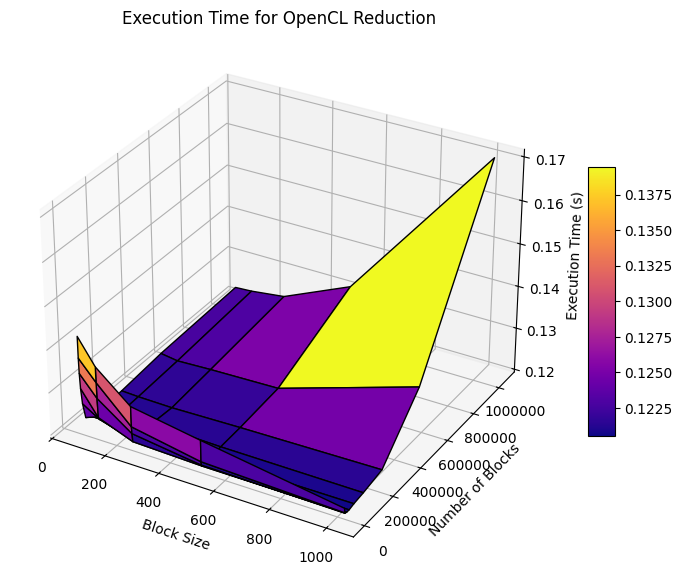

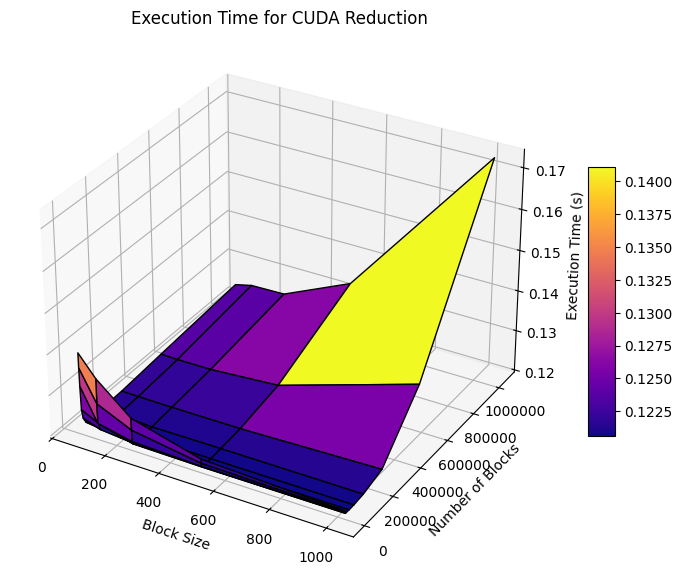

In [23]:


for target_runtime in ['OpenCL Reduction', 'CUDA Reduction']:
    df_filtered = df[df['runtime'] == target_runtime]

    block_sizes = sorted(df_filtered['block_size'].unique())
    counts = sorted(df_filtered['grid_size'].unique())

    X, Y = np.meshgrid(block_sizes, counts)
    Z = np.zeros_like(X, dtype=float)

    for i, count in enumerate(counts):
        for j, block in enumerate(block_sizes):
            match = df_filtered[
                (df_filtered['block_size'] == block) &
                (df_filtered['grid_size'] == count)
            ]
            if not match.empty:
                Z[i, j] = match['duration'].values[0]
            else:
                Z[i, j] = np.nan

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='k')
    ax.ticklabel_format(style='plain')
    ax.set_xlabel('Block Size')
    ax.set_ylabel('Number of Blocks')
    ax.set_zlabel('Execution Time (s)')
    ax.set_title(f'Execution Time for {target_runtime}')
    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.show()


Block size: 1024
Grid size: 32768
Block size: 1024
Grid size: 32768


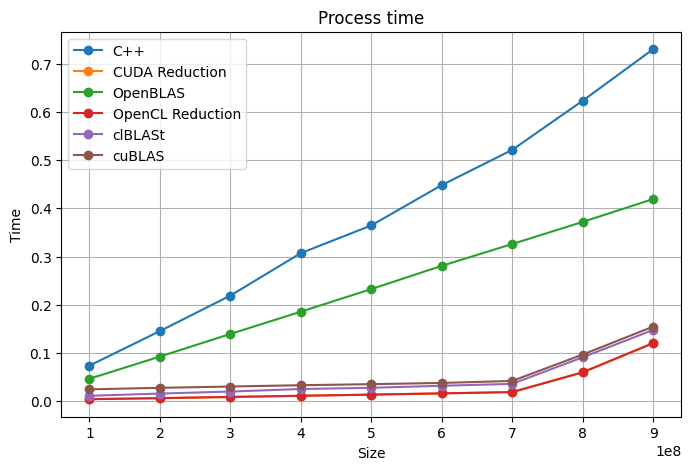

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
# plt.ticklabel_format(style='plain')

for runtime, group in df.groupby("runtime"):

    if not group['block_size'].isnull().any():
        df_max_size = group[group['size'] == group['size'].max()]

        top1 = group.loc[df_max_size['duration'].idxmin()]
        bs = top1['block_size']
        grid_size = top1['grid_size']

        print('Block size:', int(bs))
        print('Grid size:', int(grid_size))

        group = group[group['block_size'] == bs]
        group = group[group['grid_size'] == grid_size]

    plt.plot(group["size"], group["duration"], marker='o', label=runtime)

plt.xlabel("Size")
plt.ylabel("Time")
plt.title("Process time")
plt.legend()
plt.grid(True)
plt.show()
